# Полиномиальная нейронная сеть

## Общие сведения
Полиномиальная нейронная сеть - универсальный аппроксиматор, позволяющий сконструировать полиномиальную функцию, аппроксимирующую заданную, на основе малого набора данных.

Основным элементом полиномиальной сети является полиномиальный нейрон с двумя входами, одним выходом и функцией активации, вычисляющий функцию 
$$ F(\vec X) =  \vec P (\vec X)^T*\vec W  = [x_0^2, x_0, x_0 x_1, x_1, x_1^2, 1]*\left[\begin{matrix}w_0\\w_1\\\vdots\\w_5\end{matrix}\right]$$

Несколько таких нейронов объединяются в древовидную структуру
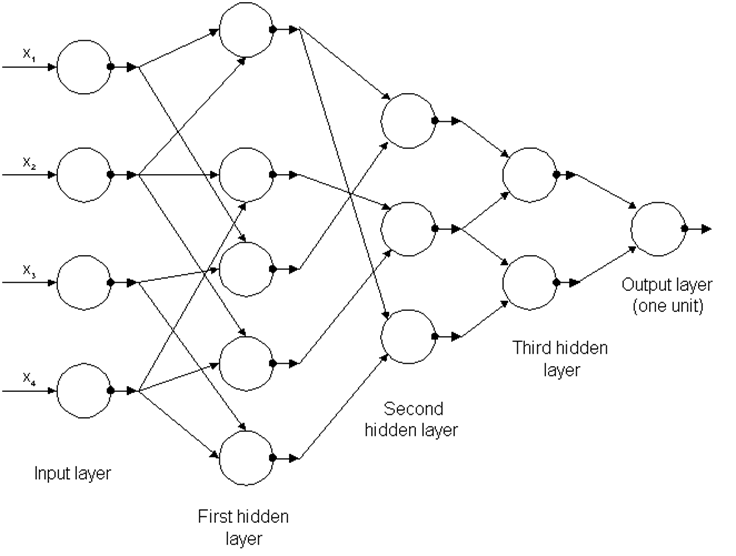!

## Пример использования

In [1]:
from scipy.io import loadmat
import time
import os
import pandas as pd
import numpy as np
import sympy
import pickle
from matplotlib import pyplot as plt

import polynomial as pln

Проверка наличия файлов в директории

In [2]:
path_to_files = "resources/"
files = os.listdir(path_to_files)
file = "subject_00"

if f"{file}.mat" not in files: 
    raise Exception(f"В папке resources не найден файл {file}.mat. Проверьте путь или скачайте файл с https://zenodo.org/record/2348892")
subj = loadmat(f"{path_to_files}/{file}.mat")

Оформим данные в pandas DataFrame для удобства манипуляции

In [3]:
electrodes = [
    'Fp1',
    'Fp2',
    'Fc5',
    'Fz',
    'Fc6',
    'T7',
    'Cz',
    'T8',
    'P7',
    'P3',
    'Pz',
    'P4',
    'P8',
    'O1',
    'Oz',
    'O2'
]
col_map = ['time']+electrodes
subj = pd.DataFrame({
    col: arr for col, arr in zip(col_map, np.transpose(subj['SIGNAL']))
})
subj.head(5)

,time,Fp1,Fp2,Fc5,Fz,Fc6,T7,Cz,T8,P7,P3,Pz,P4,P8,O1,Oz,O2
0,0.000000,2314.710938,-2473.864258,304.726593,-6740.526367,-6507.790039,-11247.854492,-2859.524170,-14004.568359,-1706.199707,-4104.730469,-6290.920410,-12415.869141,-7290.736816,170.436508,397.110260,-3278.888184
1,0.001953,2312.077393,-2477.192871,295.271210,-6747.804199,-6508.391602,-11249.747070,-2863.340820,-14008.770508,-1708.395874,-4104.203613,-6288.968262,-12418.380859,-7293.556641,175.323837,400.196503,-3276.674561
2,0.003906,2308.139160,-2477.750000,292.862305,-6750.519043,-6510.719238,-11248.869141,-2867.504883,-14007.042969,-1709.802368,-4105.119141,-6274.008301,-12422.494141,-7294.418945,193.758057,410.232483,-3263.133545
3,0.005859,2303.175293,-2477.378174,296.507050,-6756.901856,-6515.480957,-11250.728516,-2872.019775,-14011.469727,-1709.260498,-4109.889648,-6266.696777,-12422.033203,-7302.818848,197.839844,410.054993,-3260.899902
4,0.007812,2307.331543,-2471.294434,301.831573,-6754.847656,-6509.622070,-11247.145508,-2865.405518,-14011.854492,-1702.394165,-4102.324707,-6257.812012,-12413.977539,-7298.030273,200.905090,415.010742,-3255.357422


График исходных сигналов ЭЭГ:

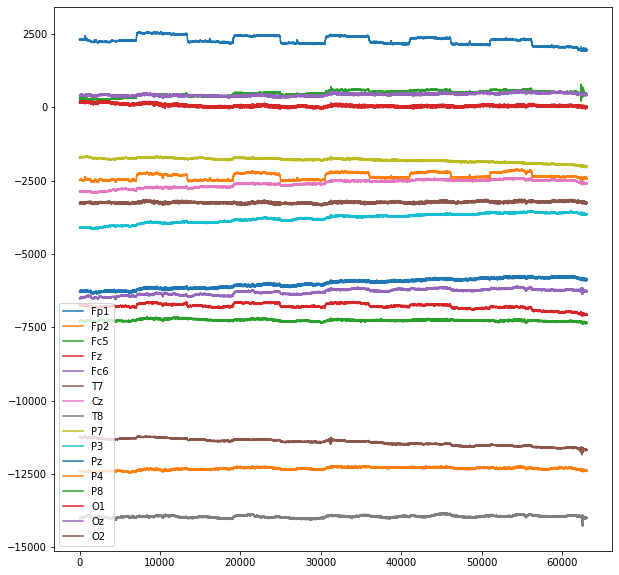

In [4]:
plt.rcParams["figure.figsize"] = (10,10)
handl = []
fig, ax = plt.subplots()
for el in electrodes:
    handl.append(ax.plot(subj[el].values, label=el)[0])
ax.legend(handles=handl)
plt.show()

Исходные параметры для расчёта.

In [5]:
max_layer=10 # максимальное число слоёв в сети

retry_num = 7 # максимальное количество попыток рачсёта при одном значении критерия сходимости
error_goal = 0.005 # целевое значение среднеквадратиченой ошибки
conv_thres_b = 0.02 # базовое значение критерия сходимости
conv_thres_min = 0.01 # минимальное значение критерия сходимости

n_points = 100 # количество точек в обучающей выборке

Генерация обучающего и контрольного наборов данных

In [6]:
train_ids = electrodes

trees = []

norm_map = {el: subj[el].values.max()-subj[el].values.min() for el in electrodes}
mean_map = {el: subj[el].mean() for el in electrodes}

И обучающий, и контрольный наборы данных должны быть отнормированы перед применением

In [7]:
control_set = {el:(subj[el].values-mean_map[el])/norm_map[el] for el in electrodes}

In [8]:
error_goal = 0.006

for train_id in train_ids:
    t = time.time()
    print(f"Начато обучение дерева для электрода {train_id}")
    conv_thres = conv_thres_b
    error = error_goal+1
    try_n = 0
    ids = np.random.randint(0, subj[train_id].size, n_points)
    ids.sort()

    training_goal = control_set[train_id][ids]
    training_set = {el:(subj[el][ids]-mean_map[el])/norm_map[el] for el in electrodes if el != train_id}
    
    while error > error_goal and conv_thres >= conv_thres_min:
        try_n +=1
        conv_thres = conv_thres_b*1/2**(try_n//retry_num)

        layer_num=1
        ntree = pln.Tree(inputs=np.array(list(training_set.keys())), restrictions=[0,1,0,1,0,1])
        ntree.regress(training_set, training_goal, conv_thres=conv_thres)
        nerror = error = ntree.error()
        while layer_num < max_layer and nerror <= error:
            layer_num+=1
            tree, error = ntree, nerror
            ntree.new_layer(restrictions=[0,1,0,1,0,1], k=5)
            ntree.regress(training_set, training_goal, conv_thres=conv_thres)
            nerror = ntree.error()
    tree.prune(top_k=1)
    trees.append(tree)
    print(f"Обучение дерева для электрода {train_id} закончено за {time.time()-t} с. Ошибка {error}")

Начато обучение дерева для электрода Fp1
Обучение дерева для электрода Fp1 закончено за 4.041365623474121 с. Ошибка 0.0015766439709157956
Начато обучение дерева для электрода Fp2
Обучение дерева для электрода Fp2 закончено за 3.758291721343994 с. Ошибка 0.0026966704419646285
Начато обучение дерева для электрода Fc5
Обучение дерева для электрода Fc5 закончено за 4.764250755310059 с. Ошибка 0.0009199598969642931
Начато обучение дерева для электрода Fz
Обучение дерева для электрода Fz закончено за 6.858693599700928 с. Ошибка 0.0018165345372853927
Начато обучение дерева для электрода Fc6
Обучение дерева для электрода Fc6 закончено за 4.262396574020386 с. Ошибка 0.002124690464828172
Начато обучение дерева для электрода T7
Обучение дерева для электрода T7 закончено за 3.56626033782959 с. Ошибка 0.001037151417222635
Начато обучение дерева для электрода Cz
Обучение дерева для электрода Cz закончено за 2.558788299560547 с. Ошибка 0.001589582376735735
Начато обучение дерева для электрода T8
Обуч

Построим графики расчитанных потенциалов ЭЭГ вместе с полученными экспериментально

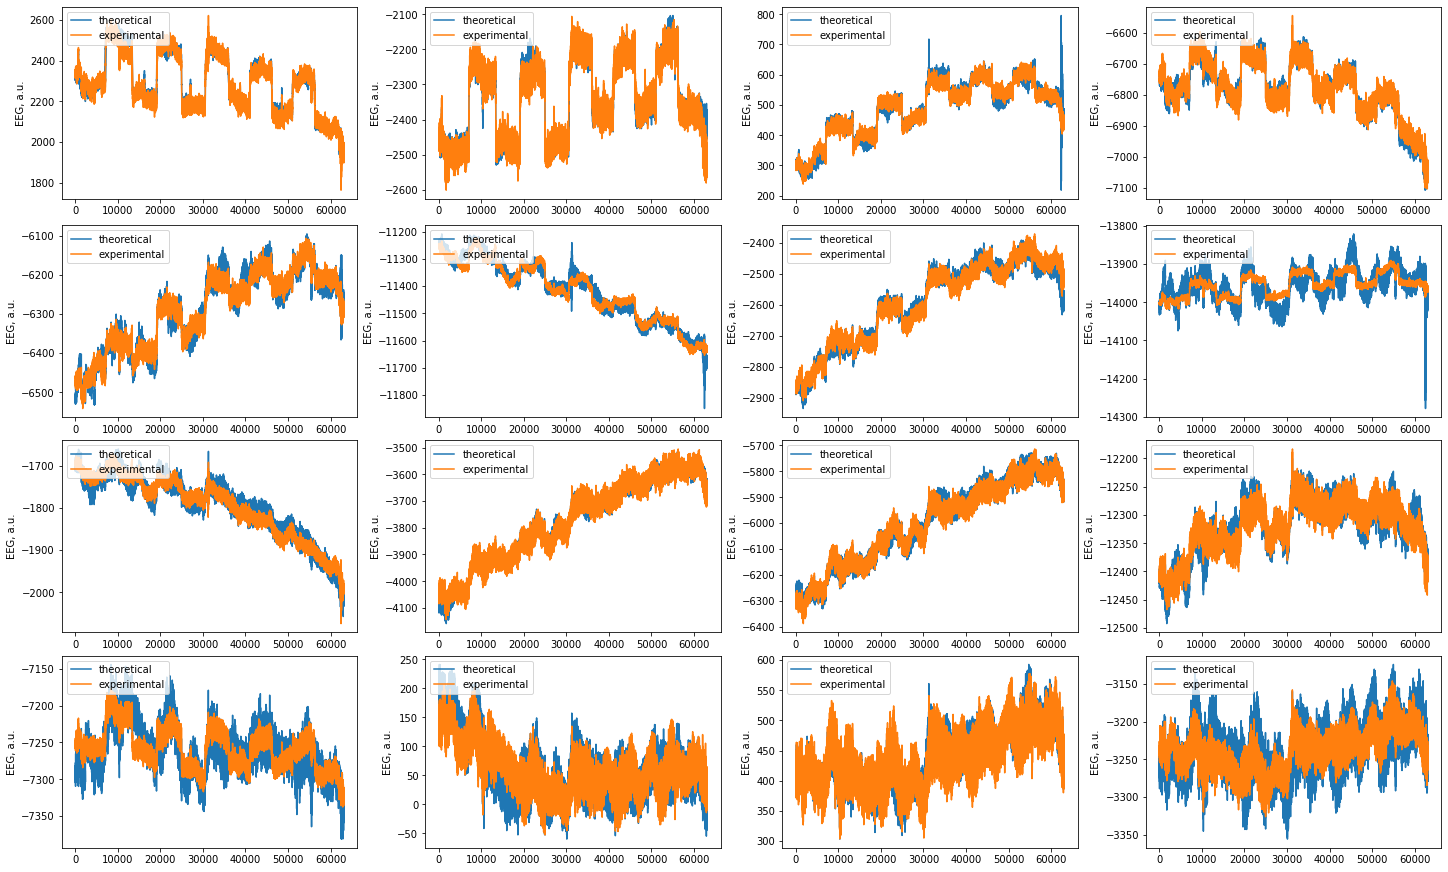

In [26]:
fig, axs = plt.subplots(4, 4, figsize=(20, 12), constrained_layout=True)
for ax, (tree, train_id) in zip(axs.flat, zip(trees, train_ids)):
    theoretical = subj[train_id]
    root_node = tree.top_layer['node'].values[0]
    #денормализуем вывод сети
    exp = tree.calculate(control_set)[root_node]*norm_map[train_id]+mean_map[train_id]
    ax.set_ylabel('EEG, a.u.')
    th, = ax.plot(theoretical, label="theoretical")
    ex, = ax.plot(exp, label="experimental")
    ax.legend(loc='upper left')
plt.show()

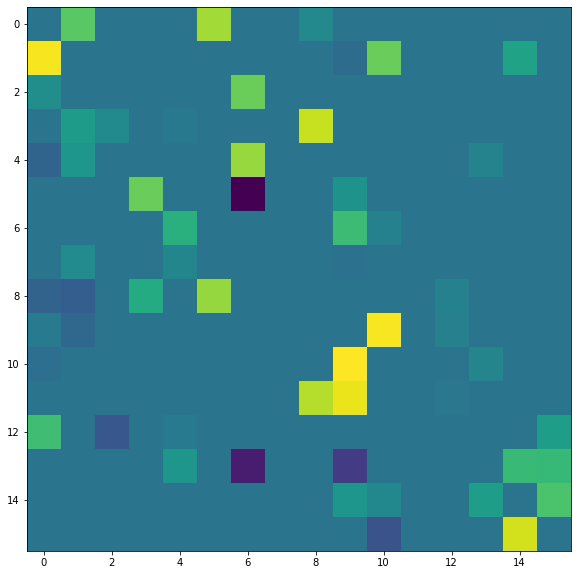

In [10]:
eqs = [t.node_to_equation() for t in trees]
mx = np.array([[eq.diff(sympy.Symbol("№"+el)) for el in electrodes] for eq in eqs], dtype=np.float32)
plt.imshow(mx, interpolation='nearest')